<a href="https://colab.research.google.com/github/willjhliang/traffic-sign-recognition/blob/main/pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
# Download dataset from github repo
!git clone --quiet https://github.com/willjhliang/traffic-sign-recognition.git
!mv traffic-sign-recognition/* .
!rm -r traffic-sign-recognition

In [2]:
from copy import deepcopy
import itertools

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('seaborn-whitegrid')
plt.rcParams["figure.figsize"] = (4, 2.5)

import torch
from torch import Tensor
from torch import nn
from torch import optim
from torch.utils import data
import torchvision

from constants import K, S, class_size, validation_ratio, random_seed
from data import load_data, consolidate_data, split_validation, visualize_data, compare_class_dist
from augment import augment_dataset, visualize_augmentation
from dimensionality_reduction import run_pca, visualize_pca, visualize_pca_per_channel, visualize_image_components
from torch_utils import load_torch_data, train_model, evaluate_model
from evaluation import generate_confusion_matrix, get_classification_report, generate_class_comparison
from explanability import visualize_top_activations, visualize_tsne_similarity, adversarial_attack

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter("ignore", category=ConvergenceWarning)

# Dataset

In [3]:
train_data = load_data('data/filtered_images/train')
test_data = load_data('data/filtered_images/test')
labels = pd.read_csv("data/filtered_labels.csv")

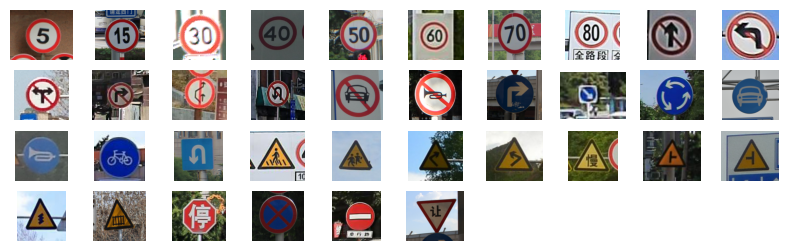

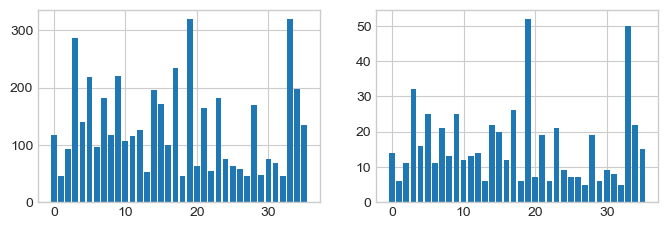

In [4]:
visualize_data(train_data)
compare_class_dist(train_data, test_data)

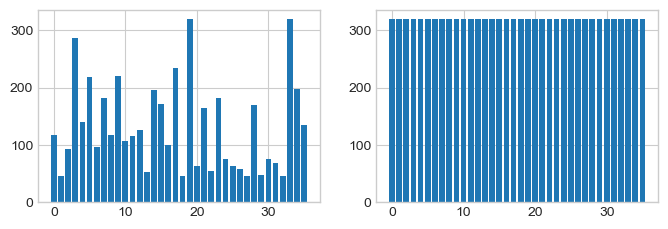

In [5]:
original_train_data = deepcopy(train_data)
train_data = augment_dataset(train_data)
compare_class_dist(original_train_data, train_data)

In [6]:
X_train, X_train_flattened, y_train = consolidate_data(train_data)
X_test, X_test_flattened, y_test = consolidate_data(test_data)

print(f'X_train shape: {X_train.shape}')
print(f'X_train_flattened shape: {X_train_flattened.shape}')
print(f'X_test shape: {X_test.shape}')

X_train shape: (11520, 3, 32, 32)
X_train_flattened shape: (11520, 3072)
X_test shape: (572, 3, 32, 32)


# Models

# Transfer Learning

In [7]:
class UpscaleDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, transform):
        self.X = X
        self.y = y
        self.transform = transform
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.numpy()
        img = self.transform(torch.from_numpy(self.X[idx].astype(np.float32)))
        label = torch.tensor(self.y[idx])

        return img, label


def load_vit_data(X_train, y_train, X_test, y_test):
    X_train, X_val, y_train, y_val = split_validation(X_train, y_train)
    transform = torchvision.transforms.Resize((224, 224))
    train_set = UpscaleDataset(X_train, y_train, transform)
    val_set = UpscaleDataset(X_val, y_val, transform)
    test_set = UpscaleDataset(X_test, y_test, transform)
    train_loader = data.DataLoader(train_set, batch_size=32, shuffle=True)
    val_loader = data.DataLoader(val_set, batch_size=32, shuffle=True)
    test_loader = data.DataLoader(test_set, batch_size=32, shuffle=True)
    return train_loader, val_loader, test_loader


def VisionTransformer():
    model = torchvision.models.vit_b_16(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False

    num_ftrs = model.heads[-1].in_features
    model.heads[-1] = nn.Sequential(
        nn.Linear(num_ftrs, 128),
        nn.Dropout(0.5),
        nn.Linear(128, K)
    )
    return model

# Training and Evaluation
We now run all the models defined above.

In [ ]:
print('========== Transfer Learning Vision Transformer ==========')
train_loader, val_loader, test_loader = load_vit_data(X_train, y_train, X_test, y_test)
model = train_model(VisionTransformer(), train_loader, val_loader, 30, 1e-3)
(y_pred_vit, y_label_vit), _ = evaluate_model(model, test_loader)

In [ ]:
vit_reportdict, vit_df = get_classification_report(y_label_vit, y_pred_vit, labels)
generate_class_comparison(vit_reportdict, 'f1-score', labels)